# Rumor Source Detection on Directed Graph

In [1]:
import math
import igraph as ig
import matplotlib.pyplot as plt

def draw_graph(graph):
    fig, ax = plt.subplots()
    ig.plot(
        graph, 
        layout="kk", 
        target=ax,
        edge_width=2,
        edge_label=graph.es["capacity"],
        vertex_size=25,
        vertex_label=range(graph.vcount()),
        edge_background="white"
        )
    plt.show()

Draw a simple example 4-node directed graph with capacities.

In [ ]:
# Example
if __name__ == "__main__":
    # Create a network
    g = ig.Graph(directed=True)
    g.add_vertices(4)
    g.add_edges([(0, 1), (0, 2), (1, 2), (2, 3)]) 
    g.es["capacity"] = [3, 2, 3, 4]

    print(g.summary())
    # print(g.get_adjacency())
    fig, ax = plt.subplots()
    ig.plot(
        g, 
        layout="kk", 
        target=ax,
        edge_width=2,
        edge_label=g.es["capacity"],
        vertex_size=25,
        vertex_label=range(g.vcount()),
        edge_background="white"
        )
    plt.show()


# Single source multicast rate

Given the source nodes can collude to encode the rumor, the capacity becomes the maximum single-source multicast rate, which is defined by 
\begin{equation}\rho_{\text{ss}}(S,A) := \min_{B\subseteq V : S\subseteq B\not\supseteq A} \lambda(B, V\setminus B).\end{equation}
To calculate the mincut function, we have
\begin{align}
    \min_{B\subseteq V : S\subseteq B\not\supseteq A} \lambda(B, V\setminus B) &= \min_{j \in A} \min_{B \subseteq V \setminus \{j\}: B \supseteq S} \lambda(B, \{j\}) \\
    &= \min_{j \in A} \text{mincut} (s, j),
\end{align}
where $s$ is the node by node contraction in $B$. The min-cut is calculated by `iGraph.mincut` method with iGraph package.

In [12]:

def rate_ss(graph, S, A):
    if A == set(): 
        return math.inf
    elif S.issubset(A): 
        return float(0)
    
    new_node = len(graph.vs)
    flows = []
    
    if len(S) == 1:
        s = list(S)[0]
        for j in A:            
            min_cut_value = graph.mincut(s, j, capacity=graph.es["capacity"]).value
            flows.append(min_cut_value)
        return min(flows)
    
    for j in A:
        mapping_vector = [i if i not in S - {j} else new_node for i in range(new_node)]
        contracted_graph = graph.copy()
        contracted_graph.contract_vertices(mapping_vector, combine_attrs={"capacity": sum})
        min_cut_value = contracted_graph.mincut(new_node, j, capacity=contracted_graph.es["capacity"]).value
        flows.append(min_cut_value)
            
    return min(flows)

According to the example, here are the results of single-source multicast rates.

In [ ]:
print(rate_ss(g, {1, 2, 3}, {2, 3}))
print(rate_ss(g, {3}, {2, 3}))
print(rate_ss(g, {0}, {2, 3}))
print(rate_ss(g, {1}, {2, 3}))
print(rate_ss(g, {0, 1}, {2, 3}))

Backward elimiation algorithm according to Listing 1 in the paper.

In [32]:
# Backward elimination algorithm
def feasible_source(graph, r, A):
    if r <= 0: raise ValueError("Rate r must be positive")
    V = {v.index for v in graph.vs}

    if rate_ss(graph, V, A) < r:
        return None
    
    S = V
    for u in V:
        if rate_ss(graph, S - {u}, A) >= r:
            S = S - {u}
    return S

If the limited rate $r = 3$, we can find the feasible source nodes $\{0, 1\}$.

In [ ]:
# Example
if __name__ == "__main__":
    # Define sink group A
    sinks = {2, 3}

    # Define the rate r
    r = 1

    # Find the feasible source group
    feasible_sources = feasible_source(g, r, sinks)
    print(f"Feasible source: {feasible_sources}")

Test on the butterfly network.

IGRAPH D--- 6 7 -- 
+ attr: capacity (e)


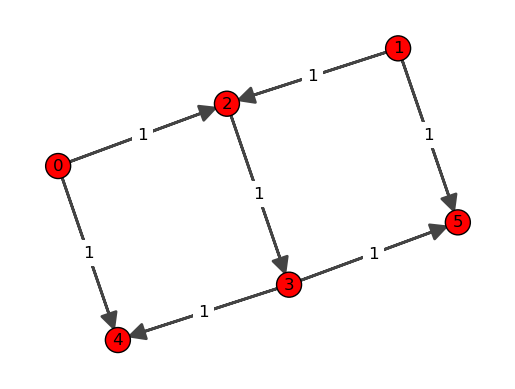

In [3]:
if __name__ == "__main__":
    # Create a network
    b = ig.Graph(directed=True)
    b.add_vertices(6)
    b.add_edges([(0, 4), (0, 2), (1, 2), (1, 5), (2, 3), (3, 4), (3, 5)]) 
    b.es["capacity"] = [1, 1, 1, 1, 1, 1, 1]

    print(b.summary())
    
    fig1, ax1 = plt.subplots()
    ig.plot(
        b, 
        layout="kk", 
        target=ax1,
        edge_width=2,
        edge_label=b.es["capacity"],
        vertex_size=25,
        vertex_label=range(b.vcount()),
        edge_background="white"
        )
    plt.show()

In [37]:
source_set = [{0}, {1}, {2}, {3}, {0, 1}, {1, 2}, {0, 1, 2}, {4}, {0, 4}, {4, 5}, {0, 1, 2, 3, 4, 5}]
for sets in source_set:
    print(f'The single source multicast rate is {rate_ss(b, sets, {4, 5})} for the source group {sets} and sink group {{4, 5}}')

The single source multicast rate is 1.0 for the source group {0} and sink group {4, 5}
The single source multicast rate is 1.0 for the source group {1} and sink group {4, 5}
The single source multicast rate is 1.0 for the source group {2} and sink group {4, 5}
The single source multicast rate is 1.0 for the source group {3} and sink group {4, 5}
The single source multicast rate is 2.0 for the source group {0, 1} and sink group {4, 5}
The single source multicast rate is 1.0 for the source group {1, 2} and sink group {4, 5}
The single source multicast rate is 2.0 for the source group {0, 1, 2} and sink group {4, 5}
The single source multicast rate is 0.0 for the source group {4} and sink group {4, 5}
The single source multicast rate is 1.0 for the source group {0, 4} and sink group {4, 5}
The single source multicast rate is 0.0 for the source group {4, 5} and sink group {4, 5}
The single source multicast rate is 2.0 for the source group {0, 1, 2, 3, 4, 5} and sink group {4, 5}


In [39]:
# Define sink group A
sinks = {4, 5}

# Define the rate limit r with a list
r_list = [0.1, 1, 1.5, 2, 3]

# Find the feasible source group
for r in r_list:
    feasible_sources = feasible_source(b, r, sinks)
    print(f"If rate limit is {r}, one of the feasible source: {feasible_sources}")

If rate limit is 0.1, one of the feasible source: {3}
If rate limit is 1, one of the feasible source: {3}
If rate limit is 1.5, one of the feasible source: {0, 1}
If rate limit is 2, one of the feasible source: {0, 1}
If rate limit is 3, one of the feasible source: None


Test on a synthetic network which contains more nodes and edges.

In the example, the underlying graph is built with 100 nodes and edge number randomly chosen between `num_nodes` and `num_nodes * (num_nodes-1)`. The capacities are $(0, 10]$. We set the rate $r = 20$ to show the feasible sources.

In [45]:
import random

min_weight, max_weight=1, 10
num_nodes = 100

G = ig.Graph(directed=True)
G.add_vertices(num_nodes)
num_edges = random.randint(num_nodes, num_nodes*(num_nodes-1))

for _ in range(num_edges):
    u = random.randint(0, num_nodes-1)
    v = random.randint(0, num_nodes-1)
    if u != v and not G.are_connected(u, v):
        G.add_edge(u, v, capacity=random.randint(min_weight, max_weight))

print(G.summary())

sink = {45, 7, 8}

rate = 1

feasible_sources = feasible_source(G, rate, sink)
print(f"One of the feasible source: {feasible_sources}")

IGRAPH D--- 100 5735 -- 
+ attr: capacity (e)
One of the feasible source: {99}


# Maximum unicast rate

If the source nodes and sink nodes can collude respectively, the capacity becomes the maximum unicast rate
\begin{equation}
    \rho_{\text{uc}}(S,A) := \min_{B\subseteq V \setminus A: S\subseteq B} \lambda(B, V\setminus B).
\end{equation}
The calculation of the mincut function is similar to the single source multicast rate.

In [ ]:
def rate_uc(graph, S, A):
    if A == set():
        return math.inf
    new_node = len(graph.vs)
    flows = []
    
    if len(S) == 1:
        s = list(S)[0]
        for j in A:            
            min_cut_value = graph.mincut(s, j, capacity=graph.es["capacity"]).value
            flows.append(min_cut_value)
        return min(flows)
    
    for j in A:
        mapping_vector = [i if i not in S - {j} else new_node for i in range(new_node)]
        contracted_graph = graph.copy()
        contracted_graph.contract_vertices(mapping_vector, combine_attrs={"capacity": sum})
        min_cut_value = contracted_graph.mincut(new_node, j, capacity=contracted_graph.es["capacity"]).value
        flows.append(min_cut_value)
            
    return min(flows)